In [1]:
# Install necessary libraries (if needed)
!pip install -q torch torchvision matplotlib scikit-learn

# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.6 MB/s eta 0:00:00


In [2]:
# Load digits dataset
digits = load_digits()
X = digits.data  # shape: (1797, 64)
y = digits.target

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=64, shuffle=False)

In [3]:
class AutoDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(AutoDecoder, self).__init__()
        self.latent_dim = latent_dim

        # Learnable latent vectors
        self.latent_codes = nn.Parameter(torch.randn(len(X_train_tensor), latent_dim))

        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64)  # Output same as input size
        )

    def forward(self, indices):
        z = self.latent_codes[indices]
        return self.decoder(z)

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
latent_dim = 16
model = AutoDecoder(latent_dim).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (batch,) in enumerate(train_loader):
        batch = batch.to(device)
        indices = batch_idx * train_loader.batch_size + torch.arange(batch.size(0))
        indices = indices.to(device)

        output = model(indices)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss:.4f}")

Epoch [1/50] Loss: 23.4881
Epoch [2/50] Loss: 22.8393
Epoch [3/50] Loss: 23.0414
Epoch [4/50] Loss: 22.6834
Epoch [5/50] Loss: 22.7228
Epoch [6/50] Loss: 22.6430
Epoch [7/50] Loss: 22.5564
Epoch [8/50] Loss: 22.5135
Epoch [9/50] Loss: 22.6140
Epoch [10/50] Loss: 22.5491
Epoch [11/50] Loss: 22.5762
Epoch [12/50] Loss: 22.5083
Epoch [13/50] Loss: 22.4616
Epoch [14/50] Loss: 22.4756
Epoch [15/50] Loss: 22.4494
Epoch [16/50] Loss: 22.6171
Epoch [17/50] Loss: 22.4990
Epoch [18/50] Loss: 22.4637
Epoch [19/50] Loss: 22.3958
Epoch [20/50] Loss: 22.5048
Epoch [21/50] Loss: 23.0233
Epoch [22/50] Loss: 22.4634
Epoch [23/50] Loss: 22.4491
Epoch [24/50] Loss: 22.4545
Epoch [25/50] Loss: 22.5285
Epoch [26/50] Loss: 23.0967
Epoch [27/50] Loss: 22.3951
Epoch [28/50] Loss: 22.4622
Epoch [29/50] Loss: 23.0917
Epoch [30/50] Loss: 22.4370
Epoch [31/50] Loss: 22.7684
Epoch [32/50] Loss: 22.4093
Epoch [33/50] Loss: 22.4335
Epoch [34/50] Loss: 22.7157
Epoch [35/50] Loss: 22.9690
Epoch [36/50] Loss: 22.4299
E

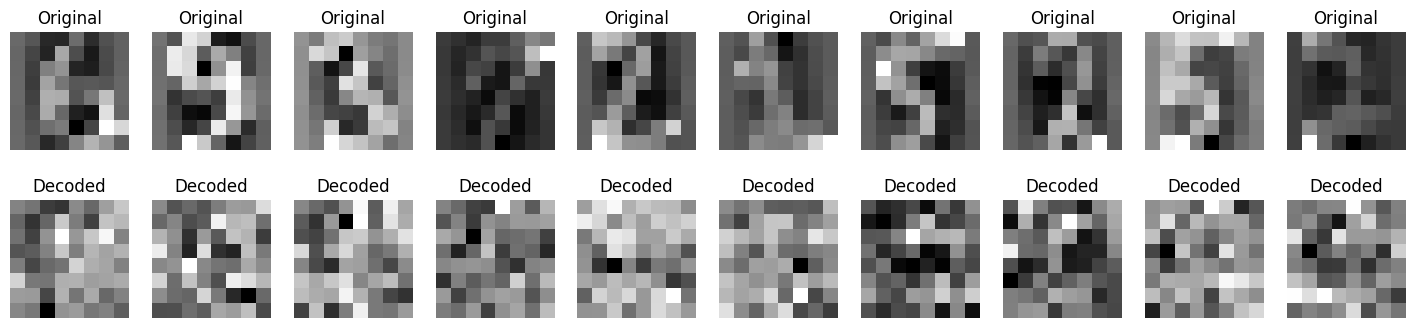

In [5]:
# Evaluation
model.eval()
with torch.no_grad():
    test_indices = torch.arange(len(X_test_tensor)).to(device)
    test_latent = torch.randn(len(X_test_tensor), latent_dim).to(device)
    decoded = model.decoder(test_latent).cpu()

# Show original vs decoded images
n = 10
plt.figure(figsize=(18, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_tensor[i].reshape(8, 8), cmap='gray')
    ax.set_title("Original")
    plt.axis("off")

    # Decoded
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i].detach().numpy().reshape(8, 8), cmap='gray')
    ax.set_title("Decoded")
    plt.axis("off")
plt.show()